## Veri Seti Yükleme ve Ön İzleme
Bu adımda, dava sonuçlarını içeren veri seti sisteme yüklenir. Veri setinin ilk birkaç satırı incelenerek değişkenlerin yapısı, türleri ve genel görünümü hakkında fikir sahibi olunur.  

Ayrıca eksik değerlerin veya tutarsızlıkların olup olmadığına dair ilk kontrol yapılır. Bu ön izleme, ilerleyen aşamalarda hangi veri temizleme veya dönüştürme işlemlerine ihtiyaç duyulacağını anlamak için önemlidir.


## 1. Veri Temizleme ve Eksik Değer İşlemleri

Veri biliminde eksik veya hatalı değerler, model performansını doğrudan etkiler. Bu nedenle ilk adım olarak veri setindeki eksik değerler tespit edilir ve uygun yöntemlerle (örneğin ortalama ile doldurma) düzeltilir.  

Bu aşamada aynı zamanda aykırı (outlier) değerlerin varlığı da gözden geçirilir. Eğer veriye zarar veriyorsa, bu gözlemler temizlenebilir veya dönüştürülebilir.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Veri yükleme
data = pd.read_csv("dava_sonuclari.csv")

print("İlk 5 satır:\n", data.head(), "\n")
print("Eksik değer sayısı:\n", data.isnull().sum(), "\n")

# Eksik değer varsa doldurma (örnek: ortalama ile)
data = data.fillna(data.mean(numeric_only=True))

# Kategorik değişkenleri encode et
data_encoded = pd.get_dummies(data, drop_first=True)

# Özellikler (X) ve hedef değişken (y)
X = data_encoded.drop("Outcome", axis=1)
y = data_encoded["Outcome"]

# İsteğe bağlı: Sayısal değişkenleri ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


İlk 5 satır:
     Case Type  Case Duration (Days)  Judge Experience (Years)  \
0    Criminal                   221                        39   
1       Civil                   212                        14   
2       Civil                    47                         6   
3  Commercial                   358                        13   
4    Criminal                    33                        17   

   Number of Witnesses  Legal Fees (USD)  Plaintiff's Reputation  \
0                   18             24306                       2   
1                    1             42444                       3   
2                   19             21418                       1   
3                    9             45005                       3   
4                   17             36315                       2   

   Defendant's Wealth (USD)  Number of Evidence Items  \
0                    663160                         3   
1                    252011                        67   
2              

## 2. Eğitim ve Test Oranı Ayarı
Modelin başarısını değerlendirebilmek için veriler eğitim ve test olarak ikiye ayrılır. Eğitim seti (%80), modelin öğrenmesi için; test seti (%20) ise öğrenilen bilginin ne kadar genellenebilir olduğunu ölçmek için kullanılır.  

Bu ayrım, modelin yalnızca gördüğü verilerde değil, görmediği yeni verilerde de başarılı olup olmadığını anlamamızı sağlar.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Eğitim veri boyutu:", X_train.shape)
print("Test veri boyutu:", X_test.shape)


Eğitim veri boyutu: (160, 12)
Test veri boyutu: (40, 12)


## 3. Decision Tree Kurulumu / Eğitimi
Bu adımda Decision Tree (Karar Ağacı) sınıflandırıcı modeli oluşturulur. Modelin hiperparametreleri (örneğin maksimum derinlik, yaprak düğüm sayısı) GridSearchCV veya manuel ayarlamalarla optimize edilebilir.  

Eğitim seti kullanılarak model verilerden öğrenir ve sınıflandırma kuralları çıkarılır. Bu sayede hedef değişkeni tahmin edebilecek karar kuralları elde edilir.


In [4]:
# Hiperparametre arama
param_grid = {
    "max_depth": [3, 4, 5, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy"
)
grid.fit(X_train, y_train)

print("En iyi parametreler:", grid.best_params_)

# Modeli kur
dt_model = grid.best_estimator_
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)


En iyi parametreler: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}


## 4. Model Performans Değerlendirme Metrikleri

Modelin başarısını tek bir metrikle değerlendirmek çoğu zaman yanıltıcıdır. Bu nedenle doğruluk (accuracy), kesinlik (precision), duyarlılık (recall) ve F1-Score gibi birden fazla metrik hesaplanır.  

Her metrik modelin farklı bir yönünü ölçer. Örneğin, precision yanlış pozitifleri azaltmaya odaklanırken recall yanlış negatifleri azaltmaya odaklanır. F1-Score ise bu ikisini dengeleyen bir ölçüdür.



Model Değerlendirme Sonuçları:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000

Detaylı Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


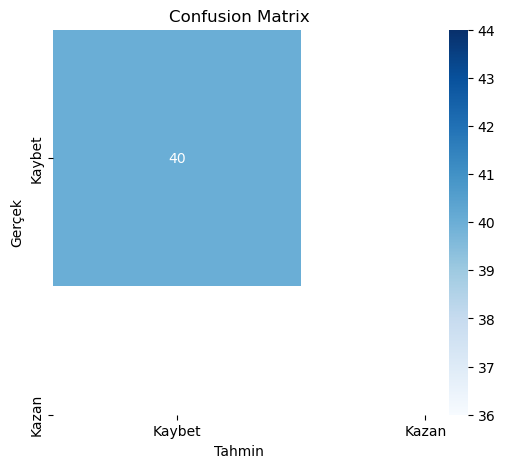

In [5]:
print("\nModel Değerlendirme Sonuçları:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print("\nDetaylı Sınıflandırma Raporu:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Kaybet", "Kazan"],
            yticklabels=["Kaybet", "Kazan"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

## 5. Karar Ağacı Analizi ve Önemli Özelliklerin İncelenmesi
Decision Tree modeli, görselleştirilerek dalların nasıl oluştuğu ve kararların hangi koşullara bağlı olarak verildiği gösterilebilir. Bu görselleştirme, modelin iç işleyişini anlamak için oldukça faydalıdır.  

Ayrıca, modelin hangi özellikleri daha önemli gördüğü analiz edilerek hangi değişkenlerin dava sonuçlarını en çok etkilediği yorumlanabilir. Böylece model sadece tahmin yapmakla kalmaz, aynı zamanda veri hakkında açıklayıcı bilgiler de sunar.


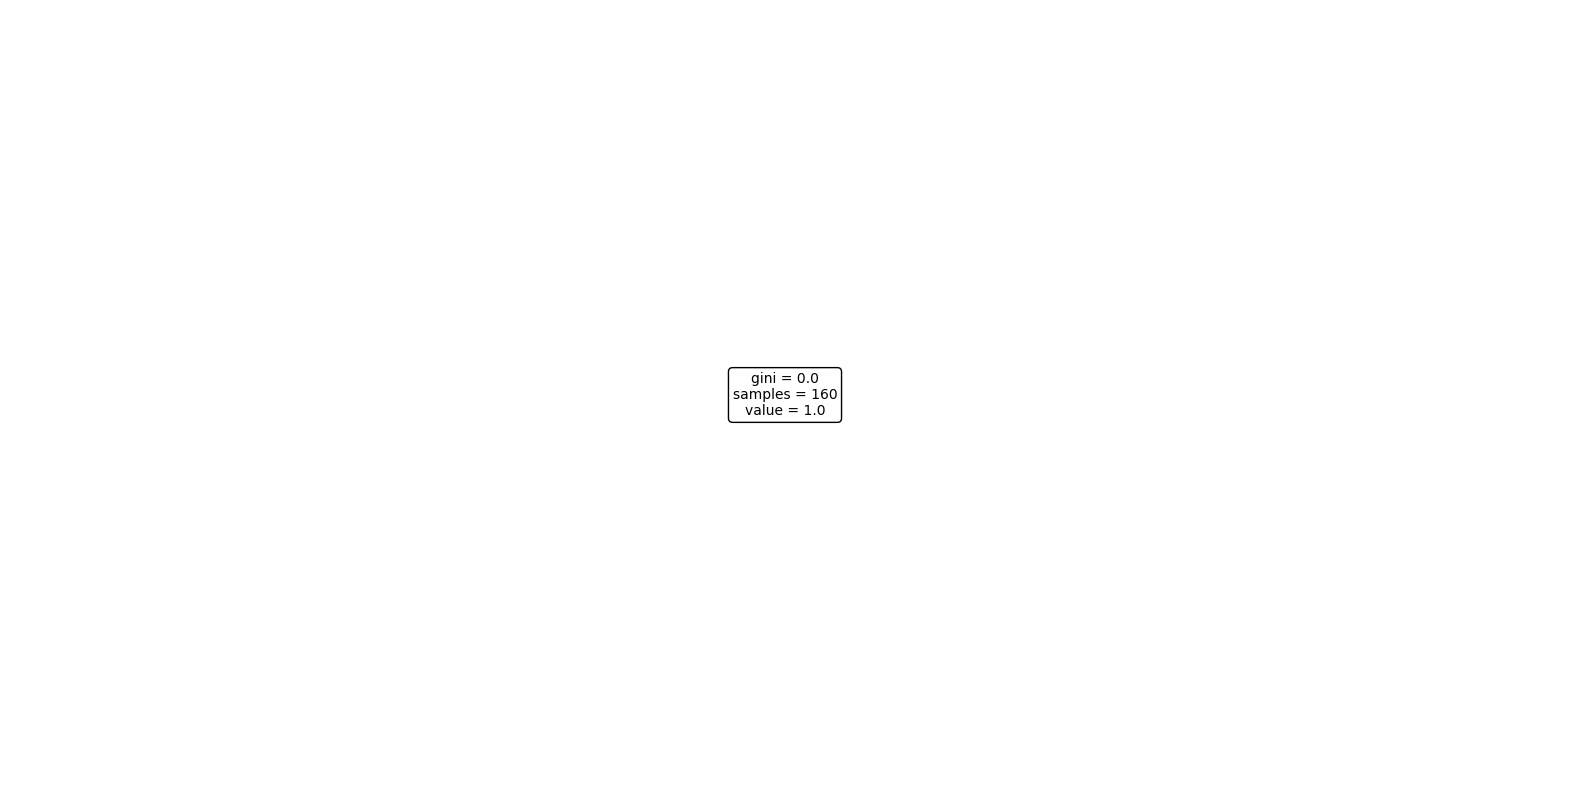

C:\Users\user\AppData\Local\Temp\ipykernel_16588\2002066924.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")


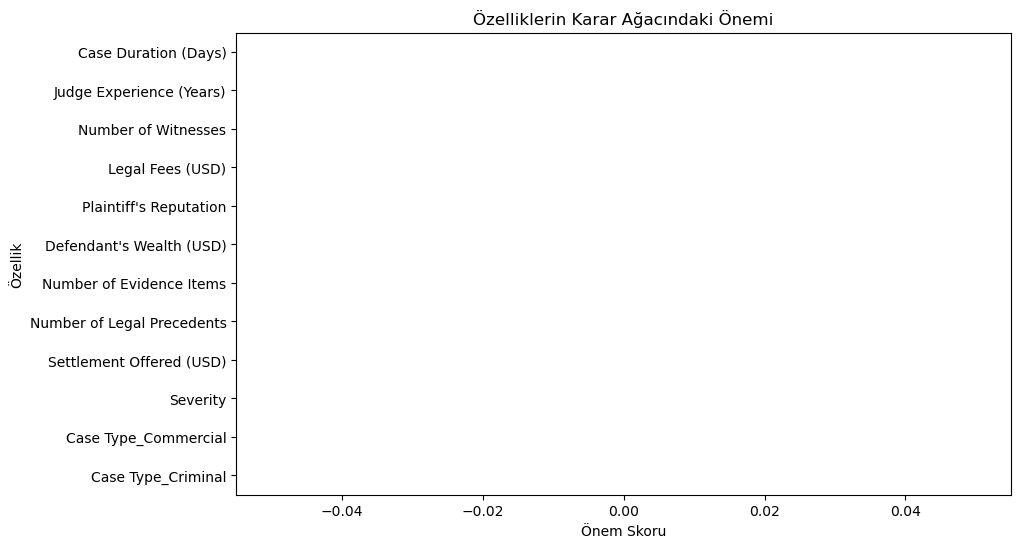


Özellik Önemleri:
 Case Duration (Days)          0.0
Judge Experience (Years)      0.0
Number of Witnesses           0.0
Legal Fees (USD)              0.0
Plaintiff's Reputation        0.0
Defendant's Wealth (USD)      0.0
Number of Evidence Items      0.0
Number of Legal Precedents    0.0
Settlement Offered (USD)      0.0
Severity                      0.0
Case Type_Commercial          0.0
Case Type_Criminal            0.0
dtype: float64


In [6]:
# Karar ağacı görselleştirme
plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["Kaybet", "Kazan"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

# Özellik önemleri
feature_importances = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title("Özelliklerin Karar Ağacındaki Önemi")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellik")
plt.show()

print("\nÖzellik Önemleri:\n", feature_importances)

# Genel Analiz

Yapılan veri ön işleme, modelleme ve görselleştirmeler; dava sonuçlarını etkileyebilecek faktörlerin incelenmesini sağlamıştır.

**Outcome** değişkeni yalnızca `0` değerini içerdiği için model tüm örnekleri aynı sınıfa atamıştır. Bu durum, test setinde mükemmel bir performans (Accuracy = 1.0) göstermesine rağmen, modelin gerçek dünyadaki genellenebilirliğini sınırlamaktadır.  

Karar ağacı görselleştirmesi, tüm yaprakların homojen olduğunu (**gini = 0.0**) ve yalnızca tek sınıfa ait örnekler içerdiğini ortaya koymuştur. Bu nedenle, dava sonucunu belirlemede hangi özelliklerin daha etkili olduğu gözlemlenememiştir.  

Veri ön işleme sürecinde eksik değer bulunmamıştır. Sayısal değişkenler farklı aralıklarda dağılmış, kategorik değişkenler ise **One-Hot Encoding** yöntemiyle dönüştürülmüştür. Böylece modelin öğrenmesi için uygun bir veri yapısı oluşturulmuştur.  

Aykırı değerler özellikle **Legal Fees** ve **Settlement Offered** değişkenlerinde gözlenmiştir. Ancak karar ağacı algoritması bu tür outlier’lara karşı görece dayanıklı olduğundan, ek bir veri çıkarımı yapılmamıştır.  

---

## Sonuç
Bu analiz, veri setindeki **sınıf dengesizliğinin** model performansını ve yorumlanabilirliğini doğrudan etkilediğini göstermektedir. Eğer **Outcome** değişkeni birden fazla sınıf içerseydi, karar ağacı görselleştirmesi üzerinden hangi faktörlerin dava sonucunu daha fazla etkilediği daha net bir şekilde yorumlanabilirdi.
